In [1]:
import datetime
import time
import requests
import pandas as pd
import hopsworks
from functions import util
import json
import os
import warnings
import requests
import numpy as np
warnings.filterwarnings("ignore")

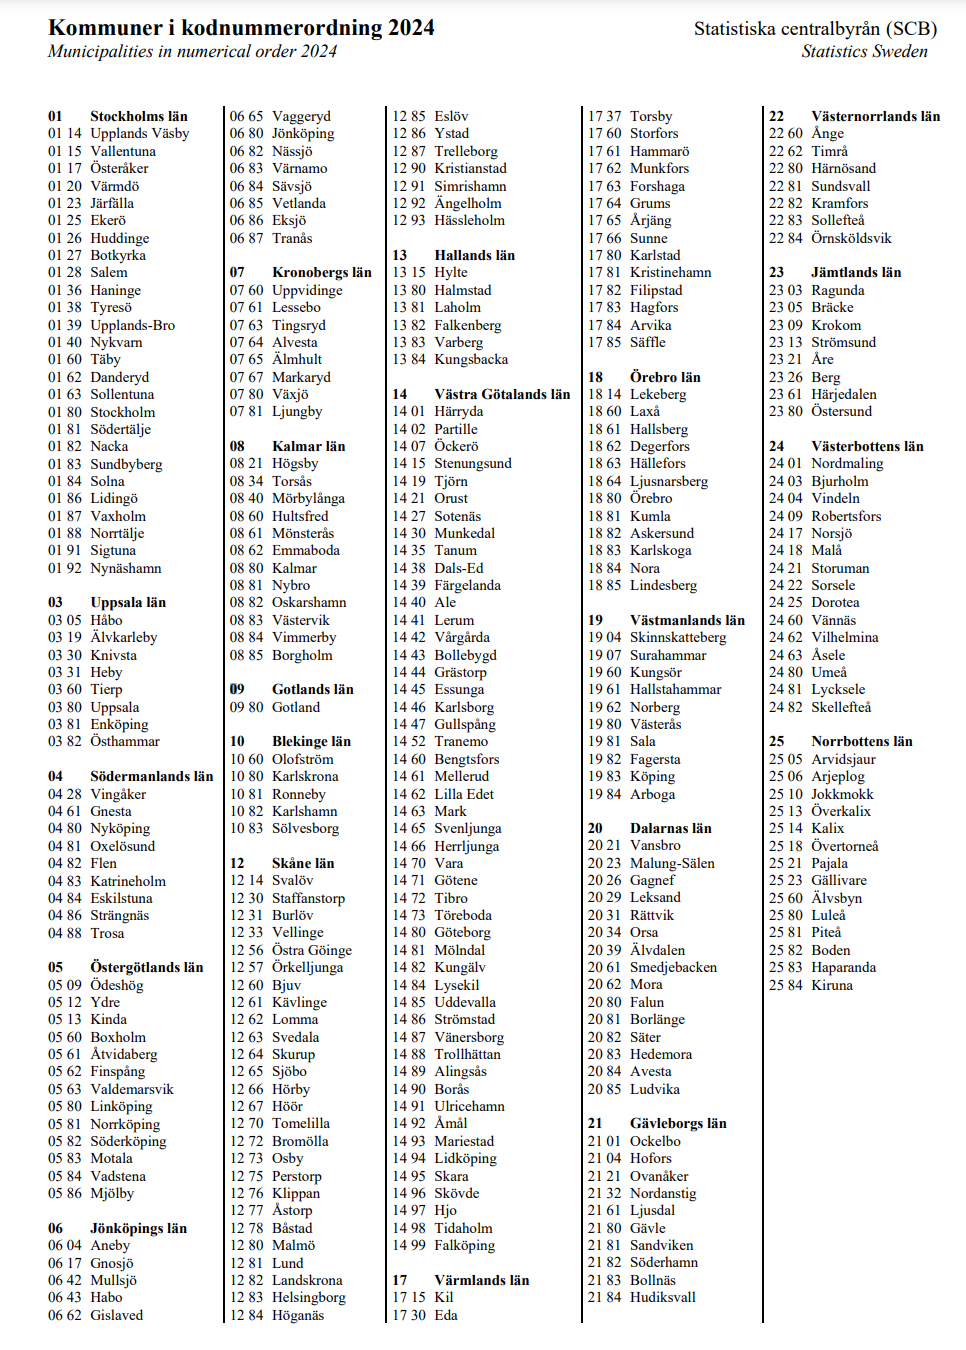

In [8]:
my_counties = ["01", "03","04","17", "19", "20"] # <-- svealand_counties

Filter on counties

In [2]:

def choose_counties(counties: list):
    """counties eg = "01" to "25"  OBS "02" non existent"""

    with open("../../data/kommuner.json", "r") as f:
        kommuner = json.load(f)

    chosen_counties = []
    for county in counties:
        chosen_counties.append(kommuner[county])

    chosen_counties = [kommun for sublist in chosen_counties for kommun in sublist]

    return chosen_counties

# choose_counties(["01", "03","04", "19"])

def filter_location(accidents, counties_list):
    locations = pd.DataFrame(columns=['name', 'gps'])
    locations['name'] = accidents['location'].apply(lambda x: x['name'])
    locations['gps'] = accidents['location'].apply(lambda x: x['gps'])

    # Filter the locations to only include those in Stockholm's counties
    stockholm_locations = locations[locations['name'].isin(counties_list)]
    return stockholm_locations
    # Display the filtered DataFrame

# Södermanland, Uppland, Västmanland, Närke, Värmland, och Dalarna.
# svealand = choose_counties(["01", "03","04","17", "19", "20"])

# accidents = get_daily_events("2025-01-07")
# svea_locations = filter_location(accidents, svealand)
# len(svea_locations),len(accidents),svea_locations

Fetch from Polisens API

In [3]:

def get_polisens_events(date):
    url = f"https://polisen.se/api/events?DateTime={date}"

    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for HTTP errors
        events = response.json()
        return events

    except requests.exceptions.RequestException as e:
        print("Error fetching data:", e)
        return None


def filter_event_type(events, type="Trafikolycka"):
    if events is None:
        return 0
    df = pd.DataFrame(events)
    filtered_events = df[df["type"].str.contains(type, na=False)]
    return filtered_events


def get_daily_events(date = None, type="Trafikolycka"):
    """Get events (accidents often) for a specific date

    Args:
        date ("YYYY-MM-DD" , optional): Defaults to todays date.
        type (str, optional): Type of report to count. Defaults to "Trafikolycka".

    Returns:
        int: Number of reports made on the specified date
    """
    
    if date is None:
        date = datetime.date.today()

    events = get_polisens_events(date)
    filtered_events = filter_event_type(events, type)
    
    return filtered_events


Select Dates

In [4]:
full_months = ["08","09","10","11","12"]

days_31 = np.arange(1,32,1).astype(str).tolist()
days_30 = np.arange(1,31,1).astype(str).tolist()
full_dates = [f"2024-{month}-{day.zfill(2)}" for month in full_months for day in (days_31 if month in ["08", "10", "12"] else days_30)]

full_dates

['2024-08-01',
 '2024-08-02',
 '2024-08-03',
 '2024-08-04',
 '2024-08-05',
 '2024-08-06',
 '2024-08-07',
 '2024-08-08',
 '2024-08-09',
 '2024-08-10',
 '2024-08-11',
 '2024-08-12',
 '2024-08-13',
 '2024-08-14',
 '2024-08-15',
 '2024-08-16',
 '2024-08-17',
 '2024-08-18',
 '2024-08-19',
 '2024-08-20',
 '2024-08-21',
 '2024-08-22',
 '2024-08-23',
 '2024-08-24',
 '2024-08-25',
 '2024-08-26',
 '2024-08-27',
 '2024-08-28',
 '2024-08-29',
 '2024-08-30',
 '2024-08-31',
 '2024-09-01',
 '2024-09-02',
 '2024-09-03',
 '2024-09-04',
 '2024-09-05',
 '2024-09-06',
 '2024-09-07',
 '2024-09-08',
 '2024-09-09',
 '2024-09-10',
 '2024-09-11',
 '2024-09-12',
 '2024-09-13',
 '2024-09-14',
 '2024-09-15',
 '2024-09-16',
 '2024-09-17',
 '2024-09-18',
 '2024-09-19',
 '2024-09-20',
 '2024-09-21',
 '2024-09-22',
 '2024-09-23',
 '2024-09-24',
 '2024-09-25',
 '2024-09-26',
 '2024-09-27',
 '2024-09-28',
 '2024-09-29',
 '2024-09-30',
 '2024-10-01',
 '2024-10-02',
 '2024-10-03',
 '2024-10-04',
 '2024-10-05',
 '2024-10-

Go through valid months (Sep-Jan) to collect backfill

In [5]:
polisens_backfill = []
polisens_dates = []
# svealand_counties = choose_counties(["01", "03","04", "19"])

for date in full_dates:
    print(date, end=": ")
    accidents = get_daily_events(date= date)
    # new
    location_acc = filter_location(accidents, my_counties)

    polisens_backfill.append(len(location_acc))
    polisens_dates.append(pd.to_datetime(date))
    print(len(location_acc), "out of ", len(accidents))

jan_days = ["01","02","03","04"]
for day in jan_days:
    print(day, end=": ")
    accidents = get_daily_events(date=f"2025-01-{day}")
    
    # new
    location_acc = filter_location(accidents, my_counties)

    polisens_dates.append(pd.to_datetime(f"2025-01-{day}").year)
    polisens_backfill.append(len(location_acc))
    print(len(location_acc), "out of ", len(accidents))


2024-08-01: 1 out of  10
2024-08-02: 4 out of  16
2024-08-03: 0 out of  9
2024-08-04: 3 out of  8
2024-08-05: 3 out of  15
2024-08-06: 1 out of  16
2024-08-07: 2 out of  10
2024-08-08: 1 out of  11
2024-08-09: 1 out of  14
2024-08-10: 2 out of  7
2024-08-11: 2 out of  7
2024-08-12: 3 out of  12
2024-08-13: 7 out of  20
2024-08-14: 3 out of  14
2024-08-15: 3 out of  14
2024-08-16: 2 out of  14
2024-08-17: 2 out of  9
2024-08-18: 2 out of  8
2024-08-19: 0 out of  19
2024-08-20: 6 out of  16
2024-08-21: 0 out of  13
2024-08-22: 3 out of  23
2024-08-23: 1 out of  15
2024-08-24: 6 out of  13
2024-08-25: 3 out of  6
2024-08-26: 1 out of  17
2024-08-27: 1 out of  20
2024-08-28: 2 out of  15
2024-08-29: 4 out of  19
2024-08-30: 1 out of  17
2024-08-31: 0 out of  9
2024-09-01: 1 out of  8
2024-09-02: 2 out of  14
2024-09-03: 4 out of  25
2024-09-04: 5 out of  16
2024-09-05: 5 out of  26
2024-09-06: 1 out of  20
2024-09-07: 2 out of  10
2024-09-08: 0 out of  14
2024-09-09: 1 out of  8
2024-09-10

Store in json

In [6]:
# Convert the list of dates to a pandas DatetimeIndex
dates_index = pd.to_datetime(polisens_dates)

# Create a DataFrame with the year, month, day, and accidents
polisen_df = pd.DataFrame({
    "year": dates_index.year,
    "month": dates_index.month,
    "day": dates_index.day,
    "accidents": polisens_backfill
})

polisen_df.head(),dates_index

(   year  month  day  accidents
 0  2024      8    1          1
 1  2024      8    2          4
 2  2024      8    3          0
 3  2024      8    4          3
 4  2024      8    5          3,
 DatetimeIndex([          '2024-08-01 00:00:00',
                          '2024-08-02 00:00:00',
                          '2024-08-03 00:00:00',
                          '2024-08-04 00:00:00',
                          '2024-08-05 00:00:00',
                          '2024-08-06 00:00:00',
                          '2024-08-07 00:00:00',
                          '2024-08-08 00:00:00',
                          '2024-08-09 00:00:00',
                          '2024-08-10 00:00:00',
                ...
                          '2024-12-26 00:00:00',
                          '2024-12-27 00:00:00',
                          '2024-12-28 00:00:00',
                          '2024-12-29 00:00:00',
                          '2024-12-30 00:00:00',
                          '2024-12-31 00:00:00',
   

In [7]:
with open("../../data/polis_svealand_accidents.csv", "w") as f:
    f.write(polisen_df.to_csv(index=False))